In [1]:
import logging
import torch
import os
import json
import numpy as np
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import sys
from torchvision import datasets, transforms as T 
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/eecs/jialin_song/anaconda3/envs/round_11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MODEL_FILEDIR = '/scratch/data/TrojAI/image-classification-sep2022-train/models/'
# CLEAN_SAMPLE_IMG_DIR = '/scratch/data/TrojAI/image-classification-sep2022-train/image-classification-sep2022-example-source-dataset'
METADATA_FILEPATH = '/scratch/data/TrojAI/image-classification-sep2022-train/METADATA.csv'
MODEL_ARCH = ['classification:' + arch for arch in ['resnet50', 'vit_base_patch32_224', 'mobilenet_v2']]
NUM_MODEL = 288
OUTPUT_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/trigger_inversion/extracted_source/'
EXTRACTED_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/trigger_inversion/extracted_source'
COLOR_CHANNEL, RESOLUTION = 3, 256

In [3]:
METADATA = pd.read_csv(METADATA_FILEPATH)

In [4]:
CLEAN_MODEL_IDS = METADATA[METADATA['poisoned'] == False]['model_name'].tolist()
TROJAN_MODEL_IDS = METADATA[METADATA['poisoned']]['model_name'].tolist()

In [5]:
def num_to_id(num, type='model'):
    if type == 'model':
        return 'id-' + str(100000000+num)[1:]
    if type == 'img':
        return 'img-' + str(100000000+num)[1:] + '.jpg'

In [6]:
resize_transforms = T.Resize(size=(66, 66))
padding_transforms = T.Pad(padding=(256-66)//2, padding_mode='constant', fill=0)
augmentation_transforms = T.Compose([T.ConvertImageDtype(torch.float)])

def process_img(img_filepath, resize=False):
    img = cv2.imread(img_filepath, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = torch.as_tensor(img)
    image = image.permute((2, 0, 1))
    if resize: 
        image = resize_transforms(image)
        image = padding_transforms(image)
    image = augmentation_transforms(image)
    return image

In [7]:
def generate_trigger(epsilon_m=5, epsilon_p=.2, seed=1, type='generic'):
    rng = np.random.default_rng(seed)

    if type == 'generic':
        mask = rng.uniform(0, 1, size=[1, RESOLUTION, RESOLUTION]).astype(np.float32)
        mask = mask / np.linalg.norm(mask) * epsilon_m

        pattern = rng.uniform(0, 1, size=[COLOR_CHANNEL, RESOLUTION, RESOLUTION]).astype(np.float32)
        pattern = pattern / np.linalg.norm(pattern) * epsilon_p

        mask = torch.from_numpy(mask)
        pattern = torch.from_numpy(pattern)
    return mask, pattern

In [9]:
def calculate_loss(prediction, label, type='generic'):
    if type == 'generic':
        ...

In [105]:
def weight_change(prev_loss, cur_loss, weights, lo=.33, hi=3):
    # loss_change = np.abs(prev_loss) / np.abs(cur_loss)
    # np.where(np.logical_and(loss_change < hi, loss_change > lo), weights, weights*loss_change)
    loss_change = np.asarray(cur_loss) - np.asarray(prev_loss)
    return np.where(loss_change < 300, weights, weights/loss_change)

In [118]:
steps = 100
# a, b, c = 10**4, 5, 10**(-2)
# a, b, c = 10**6, 1, 10**(-2)
a, b, c = 10**4, 1, 10**(-2)

In [119]:
for model_num in [3]:
    suspicious_model_id = num_to_id(model_num)

    num_classes = METADATA[METADATA['model_name'] == suspicious_model_id]['number_classes'].item()
    clean_img_filepath = os.path.join(MODEL_FILEDIR, suspicious_model_id, 'clean-example-data')
    with open(os.path.join(MODEL_FILEDIR, suspicious_model_id, 'fg_class_translation.json'), 'r') as outfile:
        model_fg_class_trans = json.load(outfile)

    raw_input, labels = [], []
    for fp in os.listdir(clean_img_filepath):
        if fp.endswith('.png'):
            raw_input.append(process_img(os.path.join(clean_img_filepath, fp)))
            with open(os.path.join(clean_img_filepath, f'{fp[:-4]}.json'), 'r') as outfile:
                labels.append(json.load(outfile))
    raw_input = torch.stack(raw_input, dim=0)
    raw_input = raw_input.requires_grad_()

    rand_seed = np.random.permutation(100)[0]
    mask, pattern = generate_trigger(epsilon_m=15, epsilon_p=.8, seed=rand_seed)
    mask, pattern = mask.requires_grad_(), pattern.requires_grad_()
    optimizer = torch.optim.Adam([pattern, mask], lr=.02, betas=(.5, .9))

    suspicious_model_filepath = os.path.join(MODEL_FILEDIR, suspicious_model_id, 'model.pt')
    suspicious_model = torch.load(suspicious_model_filepath).to(device)
    suspicious_model.eval()

    clean_models, clean_labels = [], []
    clean_model_ids = np.asarray(CLEAN_MODEL_IDS)[np.random.permutation(144)[:3]]
    for clean_model_id in clean_model_ids:
        clean_model_filepath = os.path.join(MODEL_FILEDIR, clean_model_id, 'model.pt')
        clean_model = torch.load(clean_model_filepath).to(device)
        clean_model.eval()
        clean_models.append(clean_model)

        clean_label = F.softmax(clean_model(raw_input.to(device)), dim=1)
        clean_labels.append(clean_label.cpu().detach().numpy())

    del clean_model, clean_label

    losses = []
    # weights_lst = []
    weights = np.asarray([a, b, c])

    for _ in tqdm(range(steps)):
        optimizer.zero_grad()

        input_with_trigger = (1-mask) * raw_input + mask*pattern
        input_with_trigger = torch.clamp(input_with_trigger, min=0, max=1).to(device)

        suspicious_model_pred = suspicious_model(input_with_trigger)
        suspicious_loss = F.cross_entropy(suspicious_model_pred, torch.tensor(labels).to(device))  #use kl-div

        clean_losses = []
        for ind, clean_model in enumerate(clean_models):
            clean_model_pred = F.softmax(clean_model(input_with_trigger), dim=1)
            clean_loss = F.kl_div(clean_model_pred, torch.from_numpy(clean_labels[ind]).to(device), reduction='batchmean')
            clean_losses.append(clean_loss)

        del suspicious_model_pred, clean_model_pred, clean_loss

        agg_clean_loss = torch.mean(torch.stack(clean_losses))

        reg_loss = torch.norm(mask, p=1)

        raw_losses = [suspicious_loss.item(), agg_clean_loss.item(), reg_loss.item()]

        if len(losses) != 0:
        #     weights = weight_change(losses[-1][1:], raw_losses, weights, lo=.05, hi=2)
            weights = [10, 2, 10**(-2)]

        total_loss = -1*weights[0]*suspicious_loss+ weights[1]*agg_clean_loss + weights[2]*reg_loss

        total_loss.backward()
        optimizer.step()

        with torch.no_grad():
            mask[:] = torch.clamp(mask, min=0, max=1)
            pattern[:] = torch.clamp(pattern, min=0, max=1)

        losses.append([total_loss.item(), *raw_losses])
        # weights_lst.append(weights.tolist())
    
    del suspicious_model, raw_input, optimizer, clean_models, clean_labels, clean_losses, agg_clean_loss, total_loss, input_with_trigger, suspicious_loss, reg_loss, raw_losses

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


In [120]:
import pandas as pd
import seaborn as sns

# weighted_loss = np.asarray(weights_lst)*np.asarray(losses)[:, 1:]
losses_df = pd.DataFrame(losses)

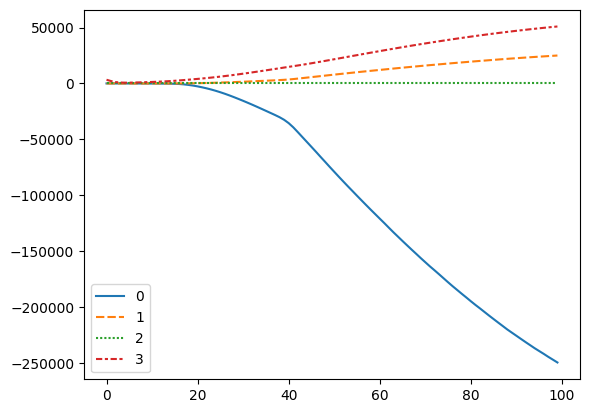

In [121]:
sns.lineplot(data=losses_df.iloc[:, :]);

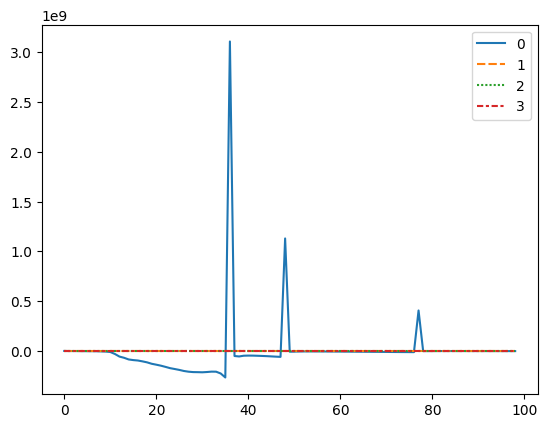

In [98]:
sns.lineplot(data=np.diff(losses, axis=0));

In [89]:
np.asarray(losses)[-2, 1:]/np.asarray(losses)[-1, 1:]

array([0.9834761 , 1.01036426, 0.98653159])

In [90]:
np.asarray(losses)[-2, 1:]-np.asarray(losses)[-1, 1:]

array([-3.20447266e+02, -3.12021375e-03, -5.14941406e+02])

In [86]:
np.asarray(losses)[-2, 1:]

array([ 1.90725117e+04, -3.04175228e-01,  3.77183320e+04])

In [87]:
np.asarray(losses)[-1, 1:]

array([ 1.93929590e+04, -3.01055014e-01,  3.82332734e+04])

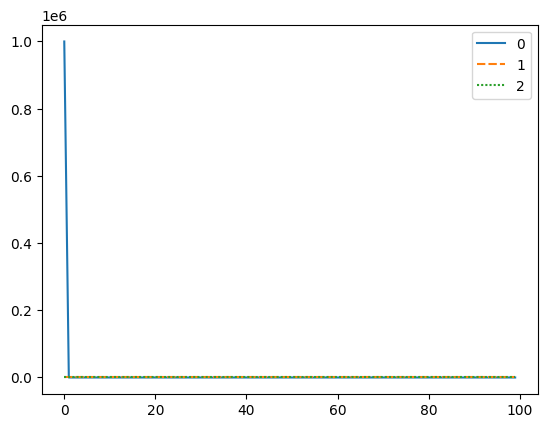

In [78]:
sns.lineplot(data=np.asarray(weights_lst));

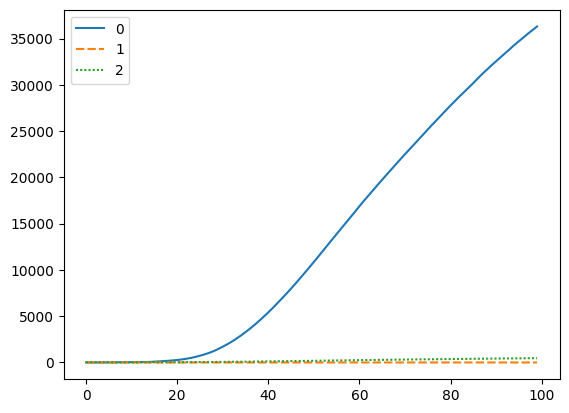

In [74]:
sns.lineplot(data=weighted_loss);

In [76]:
30000/70

428.57142857142856

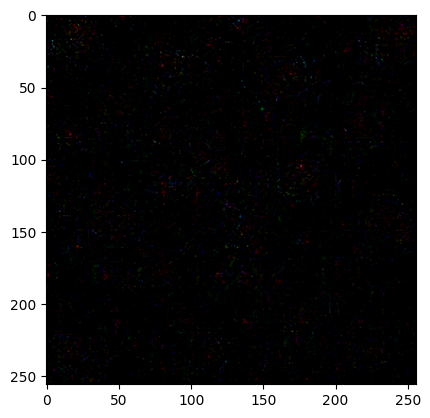

In [51]:
plt.imshow((mask*pattern).permute(1, 2, 0).detach().numpy())
plt.show()

In [55]:
suspicious_model_id = TROJAN_MODEL_IDS[0]
suspicious_model_filepath = os.path.join(MODEL_FILEDIR, suspicious_model_id, 'model.pt')
suspicious_model = torch.load(suspicious_model_filepath).to(device)
suspicious_model.eval()

clean_img_filepath = os.path.join(MODEL_FILEDIR, suspicious_model_id, 'clean-example-data')

acc, cnt = 0, 0
for fp in os.listdir(clean_img_filepath):
    if fp.endswith('.png'):
        img = process_img(os.path.join(clean_img_filepath, fp)).unsqueeze(0)
        with open(os.path.join(clean_img_filepath, f'{fp[:-4]}.json'), 'r') as outfile:
            lbl = json.load(outfile)
        acc += torch.argmax(suspicious_model(((1-mask)*img + mask*pattern).to(device)), dim=1).item() == lbl
        cnt += 1
acc/cnt   # the lower the better

1.0

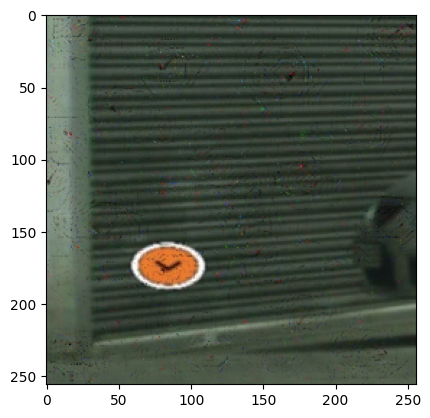

In [53]:
plt.imshow(((1-mask)*img + mask*pattern).squeeze().permute(1, 2, 0).detach().numpy())
plt.show()

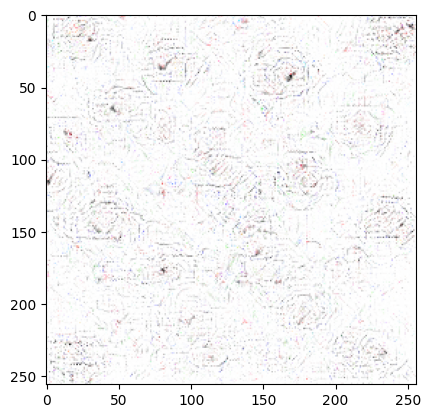

In [54]:
plt.imshow(((1-mask)*torch.ones(3, 256, 256) + mask*pattern).permute(1, 2, 0).detach().numpy())
plt.show()